In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [3]:
patient = pd.read_csv('../../CombinedData/combined1.csv')
allergies = pd.read_csv('../../CombinedData/allergies.csv')
immunizations = pd.read_csv('../../CombinedData/immunizations.csv')
conditions = pd.read_csv('../../CombinedData/conditions.csv')
medications = pd.read_csv('../../CombinedData/medications.csv')
encounters = pd.read_csv('../../CombinedData/encounters.csv')
careplans = pd.read_csv('../../CombinedData/careplans.csv')

In [4]:
patient.drop(columns=['CONDITIONS_CODE','MEDICATIONS_CODE','MEDICATIONS_REASONCODE','ENCOUNTERS_CODE','ENCOUNTERS_REASONCODE','ALLERGIES_CODE', 'IMMUNIZATIONS_CODE', 'CAREPLANS_CODE', 'CAREPLANS_REASONCODE', 'OBSERVATIONS_CODE'], inplace=True)
conditions.drop(columns=['START', 'STOP', 'ENCOUNTER', 'DESCRIPTION'], inplace=True)
medications.drop(columns=['START', 'STOP', 'ENCOUNTER', 'DESCRIPTION', 'REASONDESCRIPTION'], inplace=True)
immunizations.drop(columns=['DATE', 'ENCOUNTER', 'DESCRIPTION'], inplace=True)
allergies.drop(columns=['START', 'STOP', 'ENCOUNTER', 'DESCRIPTION'], inplace=True)
encounters.drop(columns=['DATE', 'ID', 'DESCRIPTION', 'REASONDESCRIPTION'], inplace=True)
careplans.drop(columns=['ID', 'START', 'STOP', 'ENCOUNTER', 'DESCRIPTION', 'REASONDESCRIPTION'], inplace=True)

In [5]:
patient.isna().sum()
columns_to_fill_with_mode = ['RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ZIP']

In [6]:
for column in columns_to_fill_with_mode:
    mode_value = patient[column].mode()[0]
    patient[column].fillna(mode_value, inplace=True)
    
patient['MARITAL'] = patient['MARITAL'].fillna('S')
patient['DEATHDATE'] = patient['DEATHDATE'].fillna('False')
patient['PASSPORT'] = patient['PASSPORT'].apply(lambda x: x.lower() != 'false')
columns_to_normalize = ['RACE', 'ETHNICITY', 'PASSPORT', 'BIRTHPLACE'] 

In [7]:
# Create a LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each column
patient[columns_to_normalize] = patient[columns_to_normalize].apply(label_encoder.fit_transform)

patient['MARITAL'] = patient['MARITAL'].apply(lambda x: 0 if x == 'S' else 1)

# Map 'M' to 1 and 'F' to 0 in the 'GENDER' column
patient['GENDER'] = patient['GENDER'].apply(lambda x: 0 if x == 'F' else 1)

patient.isna().sum()
# Convert 'BIRTHDATE' to datetime, handling errors by setting problematic values to NaN
patient['BIRTHDATE'] = pd.to_datetime(patient['BIRTHDATE'], errors='coerce')

# Drop rows with NaN values in 'BIRTHDATE'
patient = patient.dropna(subset=['BIRTHDATE'])

# Assuming you have cleaned the 'BIRTHDATE' column, you can proceed with the reference date
reference_date = pd.to_datetime('2023-01-01')

# Calculate age
patient['AGE'] = (reference_date - patient['BIRTHDATE']).dt.days // 365.25

# Convert 'DEATHDATE' to datetime, handling errors by setting problematic values to NaT
patient['DEATHDATE'] = pd.to_datetime(patient['DEATHDATE'], errors='coerce')

# Calculate age at death if available
patient['AGE_AT_DEATH'] = (patient['DEATHDATE'] - patient['BIRTHDATE']).dt.days // 365.25

# Replace NaT with 0 in 'AGE_AT_DEATH' for patients who are not deceased
patient['AGE_AT_DEATH'] = patient['AGE_AT_DEATH'].fillna(0)

patient.head()

/var/folders/33/9x78v0zs43q5dygckhsgm6380000gn/T/ipykernel_13713/479669731.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  patient['DEATHDATE'] = pd.to_datetime(patient['DEATHDATE'], errors='coerce')


,ID,BIRTHDATE,DEATHDATE,PASSPORT,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ZIP,BODY_WEIGHT,BODY_HEIGHT,BMI,SYSTOLIC_BP,DIASTOLIC_BP,AGE,AGE_AT_DEATH
0,660bec03-9e58-47f2-98b9-2f1c564f3838,1996-07-26,NaT,0,0,43,59,0,119,20810.0,73.54,163.07,27.66,101.0,75.0,26.0,0.0
1,5125d2b2-3aef-4ae2-aa5c-335f7e206b92,1996-09-24,NaT,0,0,43,56,0,363,2638.0,17.33,95.92,18.84,137.0,89.0,26.0,0.0
2,26626faf-cbd5-48d5-a3bf-a7b21ae08e4b,1944-09-01,2015-09-04,1,1,43,59,1,117,23401.0,74.58,174.14,24.60,111.0,71.0,78.0,71.0
3,eed62b4a-1099-47ec-a2ac-d953830b44d6,1965-08-05,NaT,0,1,41,48,1,304,2631.0,113.23,164.74,41.72,131.0,86.0,57.0,0.0
4,6e9f8b3e-5a21-401e-868d-2d62e0e7f452,1979-11-03,NaT,1,1,43,59,0,377,2630.0,106.81,166.13,38.70,131.0,74.0,43.0,0.0


In [8]:
allergies = allergies.rename(columns={'CODE': 'ALLERGIES_CODE'})
allergies.isna().sum()

PATIENT           0
ALLERGIES_CODE    0
dtype: int64

In [9]:
conditions = conditions.rename(columns={'CODE': 'CONDITIONS_CODE'})
conditions.isna().sum()

PATIENT            0
CONDITIONS_CODE    0
dtype: int64

In [10]:
medications = medications.rename(columns={'CODE': 'MEDICATIONS_CODE'})
medications = medications.rename(columns={'REASONCODE': 'MEDICATIONS_REASONCODE'})
medications.isna().sum()

PATIENT                        0
MEDICATIONS_CODE               0
MEDICATIONS_REASONCODE    118792
dtype: int64

In [11]:
medications.fillna(0, inplace=True)
medications.isna().sum()

PATIENT                   0
MEDICATIONS_CODE          0
MEDICATIONS_REASONCODE    0
dtype: int64

In [12]:
immunizations = immunizations.rename(columns={'CODE': 'IMMUNIZATIONS_CODE'})
immunizations.isna().sum()

PATIENT               0
IMMUNIZATIONS_CODE    0
dtype: int64

In [13]:
encounters = encounters.rename(columns={'CODE': 'ENCOUNTERS_CODE'})
encounters = encounters.rename(columns={'REASONCODE': 'ENCOUNTERS_REASONCODE'})
encounters.isna().sum()

PATIENT                       0
ENCOUNTERS_CODE               0
ENCOUNTERS_REASONCODE    907763
dtype: int64

In [14]:
encounters.fillna(0, inplace=True)
encounters.isna().sum()

PATIENT                  0
ENCOUNTERS_CODE          0
ENCOUNTERS_REASONCODE    0
dtype: int64

In [15]:
careplans = careplans.rename(columns={'CODE': 'CAREPLANS_CODE'})
careplans = careplans.rename(columns={'REASONCODE': 'CAREPLANS_REASONCODE'})
careplans.isna().sum()

PATIENT                     0
CAREPLANS_CODE              0
CAREPLANS_REASONCODE    94889
dtype: int64

In [16]:
careplans.fillna(0, inplace=True)
careplans.isna().sum()

PATIENT                 0
CAREPLANS_CODE          0
CAREPLANS_REASONCODE    0
dtype: int64

In [17]:
allergies_immu_df = pd.merge(allergies, immunizations, on='PATIENT', how='left')

In [18]:
all_immu_encou_df = pd.merge(allergies_immu_df, encounters, on='PATIENT', how='left').merge(conditions, on='PATIENT', how='left')
all_immu_encou_df.head()

,PATIENT,ALLERGIES_CODE,IMMUNIZATIONS_CODE,ENCOUNTERS_CODE,ENCOUNTERS_REASONCODE,CONDITIONS_CODE
0,5125d2b2-3aef-4ae2-aa5c-335f7e206b92,91930004,140.0,371883000,0.0,232353008.0
1,5125d2b2-3aef-4ae2-aa5c-335f7e206b92,91930004,140.0,371883000,0.0,74400008.0
2,5125d2b2-3aef-4ae2-aa5c-335f7e206b92,91930004,140.0,371883000,0.0,428251008.0
3,5125d2b2-3aef-4ae2-aa5c-335f7e206b92,91930004,140.0,185347001,0.0,232353008.0
4,5125d2b2-3aef-4ae2-aa5c-335f7e206b92,91930004,140.0,185347001,0.0,74400008.0


In [19]:
med_care_df = pd.merge(careplans, medications, on='PATIENT', how='left').merge(conditions, on='PATIENT', how='left')
med_care_df.head()

,PATIENT,CAREPLANS_CODE,CAREPLANS_REASONCODE,MEDICATIONS_CODE,MEDICATIONS_REASONCODE,CONDITIONS_CODE
0,660bec03-9e58-47f2-98b9-2f1c564f3838,872781000000100,39848009.0,834060.0,43878008.0,39848009.0
1,660bec03-9e58-47f2-98b9-2f1c564f3838,872781000000100,39848009.0,834060.0,43878008.0,10509002.0
2,660bec03-9e58-47f2-98b9-2f1c564f3838,872781000000100,39848009.0,834060.0,43878008.0,444814009.0
3,660bec03-9e58-47f2-98b9-2f1c564f3838,872781000000100,39848009.0,834060.0,43878008.0,38341003.0
4,660bec03-9e58-47f2-98b9-2f1c564f3838,872781000000100,39848009.0,834060.0,43878008.0,283371005.0


In [20]:
patient_merge = pd.merge(patient, conditions, left_on='ID', right_on='PATIENT', how='left')
patient_merge.head()

,ID,BIRTHDATE,DEATHDATE,PASSPORT,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ZIP,BODY_WEIGHT,BODY_HEIGHT,BMI,SYSTOLIC_BP,DIASTOLIC_BP,AGE,AGE_AT_DEATH,PATIENT,CONDITIONS_CODE
0,660bec03-9e58-47f2-98b9-2f1c564f3838,1996-07-26,NaT,0,0,43,59,0,119,20810.0,73.54,163.07,27.66,101.0,75.0,26.0,0.0,660bec03-9e58-47f2-98b9-2f1c564f3838,39848009.0
1,660bec03-9e58-47f2-98b9-2f1c564f3838,1996-07-26,NaT,0,0,43,59,0,119,20810.0,73.54,163.07,27.66,101.0,75.0,26.0,0.0,660bec03-9e58-47f2-98b9-2f1c564f3838,10509002.0
2,660bec03-9e58-47f2-98b9-2f1c564f3838,1996-07-26,NaT,0,0,43,59,0,119,20810.0,73.54,163.07,27.66,101.0,75.0,26.0,0.0,660bec03-9e58-47f2-98b9-2f1c564f3838,444814009.0
3,660bec03-9e58-47f2-98b9-2f1c564f3838,1996-07-26,NaT,0,0,43,59,0,119,20810.0,73.54,163.07,27.66,101.0,75.0,26.0,0.0,660bec03-9e58-47f2-98b9-2f1c564f3838,38341003.0
4,660bec03-9e58-47f2-98b9-2f1c564f3838,1996-07-26,NaT,0,0,43,59,0,119,20810.0,73.54,163.07,27.66,101.0,75.0,26.0,0.0,660bec03-9e58-47f2-98b9-2f1c564f3838,283371005.0


In [21]:
# These codes are the ones that correlate to a type of lung cancer
conditions_code = set([162573006, 254637007, 432121009, 424132000, 422968005, 254632001, 67821000119109])
patient_merge.drop(columns=['DEATHDATE', 'BIRTHDATE', 'PATIENT', 'ID'], inplace=True)
med_care_df.drop(columns=['PATIENT'], inplace=True)
all_immu_encou_df.drop(columns=['PATIENT'], inplace=True)
# Create a 'CODE' column in conditions DataFrame
patient_merge['TARGET'] = conditions['CONDITIONS_CODE'].apply(lambda code: 1 if code in conditions_code else 0)
med_care_df['TARGET'] = conditions['CONDITIONS_CODE'].apply(lambda code: 1 if code in conditions_code else 0)
all_immu_encou_df['TARGET'] = conditions['CONDITIONS_CODE'].apply(lambda code: 1 if code in conditions_code else 0)

#fill any missing codes with 0 meaning there were no inputs
patient_merge.fillna(0, inplace=True)
med_care_df.fillna(0, inplace=True)
all_immu_encou_df.fillna(0, inplace=True)

In [22]:
X = patient_merge.drop(columns='TARGET')
y = patient_merge['TARGET']

# Instantiate the SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and apply the SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the balanced data
balanced_df1 = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='TARGET')], axis=1)

# Check the balance
print(balanced_df1['TARGET'].value_counts())

TARGET
0    427910
1    427910
Name: count, dtype: int64


In [23]:
X = med_care_df.drop(columns='TARGET')
y = med_care_df['TARGET']

# Instantiate the SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and apply the SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the balanced data
balanced_df2 = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='TARGET')], axis=1)

# Check the balance
print(balanced_df2['TARGET'].value_counts())

TARGET
0.0    22608821
1.0    22608821
Name: count, dtype: int64


In [24]:
X = all_immu_encou_df.drop(columns='TARGET')
y = all_immu_encou_df['TARGET']

# Instantiate the SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and apply the SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the balanced data
balanced_df3 = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='TARGET')], axis=1)

# Check the balance
print(balanced_df3['TARGET'].value_counts())

TARGET
0.0    65963899
1.0    65963899
Name: count, dtype: int64


In [25]:
balanced_df1.head()

,PASSPORT,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ZIP,BODY_WEIGHT,BODY_HEIGHT,BMI,SYSTOLIC_BP,DIASTOLIC_BP,AGE,AGE_AT_DEATH,CONDITIONS_CODE,TARGET
0,0,0,43,59,0,119,20810.0,73.54,163.07,27.66,101.0,75.0,26.0,0.0,39848009.0,0
1,0,0,43,59,0,119,20810.0,73.54,163.07,27.66,101.0,75.0,26.0,0.0,10509002.0,0
2,0,0,43,59,0,119,20810.0,73.54,163.07,27.66,101.0,75.0,26.0,0.0,444814009.0,0
3,0,0,43,59,0,119,20810.0,73.54,163.07,27.66,101.0,75.0,26.0,0.0,38341003.0,0
4,0,0,43,59,0,119,20810.0,73.54,163.07,27.66,101.0,75.0,26.0,0.0,283371005.0,0


In [26]:
balanced_df2.head()


,CAREPLANS_CODE,CAREPLANS_REASONCODE,MEDICATIONS_CODE,MEDICATIONS_REASONCODE,CONDITIONS_CODE,TARGET
0,872781000000100,39848009.0,834060.0,43878008.0,39848009.0,0.0
1,872781000000100,39848009.0,834060.0,43878008.0,10509002.0,0.0
2,872781000000100,39848009.0,834060.0,43878008.0,444814009.0,0.0
3,872781000000100,39848009.0,834060.0,43878008.0,38341003.0,0.0
4,872781000000100,39848009.0,834060.0,43878008.0,283371005.0,0.0


In [27]:
balanced_df3.head()


,ALLERGIES_CODE,IMMUNIZATIONS_CODE,ENCOUNTERS_CODE,ENCOUNTERS_REASONCODE,CONDITIONS_CODE,TARGET
0,91930004,140.0,371883000,0.0,232353008.0,0.0
1,91930004,140.0,371883000,0.0,74400008.0,0.0
2,91930004,140.0,371883000,0.0,428251008.0,0.0
3,91930004,140.0,185347001,0.0,232353008.0,0.0
4,91930004,140.0,185347001,0.0,74400008.0,0.0


In [28]:
features1 = ['PASSPORT','MARITAL','RACE','ETHNICITY','GENDER','BIRTHPLACE','ZIP','BODY_WEIGHT','BODY_HEIGHT','BMI','SYSTOLIC_BP','DIASTOLIC_BP','AGE','AGE_AT_DEATH','CONDITIONS_CODE']
features2 = ['CAREPLANS_CODE', 'CAREPLANS_REASONCODE', 'MEDICATIONS_CODE', 'MEDICATIONS_REASONCODE', 'CONDITIONS_CODE']
features3 = ['ALLERGIES_CODE', 'IMMUNIZATIONS_CODE', 'ENCOUNTERS_CODE', 'ENCOUNTERS_REASONCODE', 'CONDITIONS_CODE']
Y1 = balanced_df1['TARGET']
Y2 = balanced_df2['TARGET']
Y3 = balanced_df3['TARGET']
X1 = balanced_df1[features1]
X2 = balanced_df2[features2]
X3 = balanced_df3[features3]

# Split the data into training and test sets
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, test_size=0.2, random_state=42)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.2, random_state=42)
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, Y3, test_size=0.2, random_state=42)


In [29]:
scaler = StandardScaler()
X_train1_scaled = scaler.fit_transform(X_train1)
X_test_1scaled = scaler.transform(X_test1)
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)
X_train3_scaled = scaler.fit_transform(X_train3)
X_test3_scaled = scaler.transform(X_test3)

In [30]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [31]:
model1 = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)
model2 = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)
model3 = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)

In [32]:
# Fit the model to the training data
model1.fit(X_train1, Y_train1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
model2.fit(X_train2, Y_train2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
model3.fit(X_train3, Y_train3)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [35]:
Y_pred1 = model1.predict(X_test1)

In [36]:
Y_pred2 = model2.predict(X_test2)

In [37]:
Y_pred3 = model3.predict(X_test3)

In [38]:
mse1 = mean_squared_error(Y_test1, Y_pred1)

In [39]:
mse2 = mean_squared_error(Y_test2, Y_pred2)

In [40]:
mse3 = mean_squared_error(Y_test3, Y_pred3)

In [41]:
print(f"Mean Squared Error on Test Set: {mse1}")

Mean Squared Error on Test Set: 0.05658757746613925


In [42]:
print(f"Mean Squared Error on Test Set: {mse2}")

Mean Squared Error on Test Set: 0.08804669950126522


In [43]:
print(f"Mean Squared Error on Test Set: {mse3}")

Mean Squared Error on Test Set: 0.10877253431370432


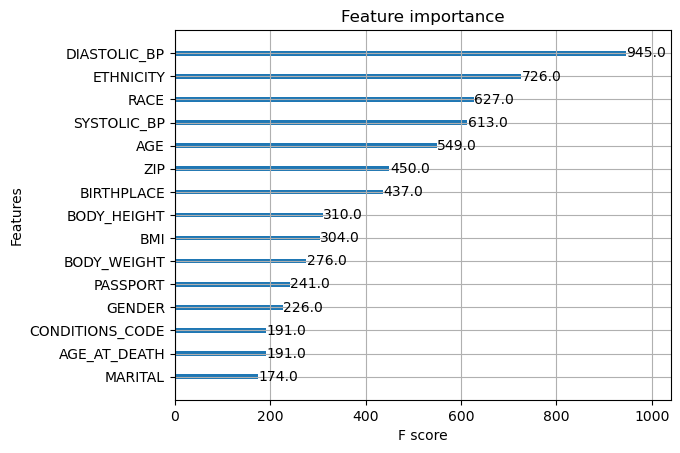

In [44]:
xgb.plot_importance(model1)
plt.show()

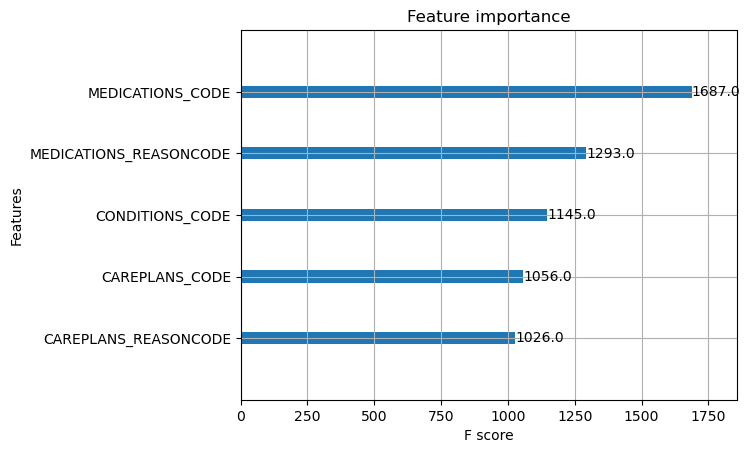

In [45]:
xgb.plot_importance(model2)
plt.show()

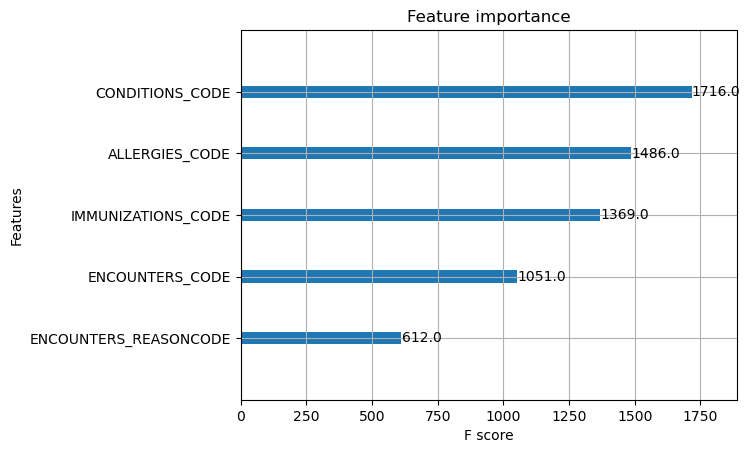

In [46]:
xgb.plot_importance(model3)
plt.show()